<a href="https://colab.research.google.com/github/Alishahu16/Market-Inflation/blob/main/Optuna_Tuning_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install optuna xgboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.7 MB/s eta 0:00:00


In [ ]:
import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd



In [ ]:
# Load your data (assuming 'Merged dataset.xlsx' is the data file)
Data = pd.read_excel('Merged dataset.xlsx')

In [ ]:
# Define the weights for each item (based on their importance in the consumption basket)
weights = {
    'Rice Inflation Rate (%)': 0.135,
    'Gasoline Inflation Rate (%)': 3.261,
    'Milk Inflation Rate (%)': 0.174,
    'Egg Inflation Rate (%)': 1.725
}

In [ ]:
# Calculate the overall inflation as a weighted sum of individual inflation rates
Data['Overall Inflation Rate (%)'] = (
    Data['Rice Inflation Rate (%)'] * weights['Rice Inflation Rate (%)'] +
    Data['Gasoline Inflation Rate (%)'] * weights['Gasoline Inflation Rate (%)'] +
    Data['Milk Inflation Rate (%)'] * weights['Milk Inflation Rate (%)'] +
    Data['Egg Inflation Rate (%)'] * weights['Egg Inflation Rate (%)']
)

In [ ]:
# Extract features and target
X = Data.drop(columns=["Overall Inflation Rate (%)"])
y = Data["Overall Inflation Rate (%)"]

In [ ]:
# Define the Optuna objective function
def objective(trial):
    # Define hyperparameters for XGBoost
    param = {
        "objective": "reg:squarederror",  # Regression task
        "eval_metric": "rmse",
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "alpha": trial.suggest_float("alpha", 1e-8, 10.0),
        "lambda": trial.suggest_float("lambda", 1e-8, 10.0),
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
    }

    # Split the data
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

    # convert 'Date' to ordinal and update the column in X_train and X_valid
    X_train['Date'] = pd.to_datetime(X_train['Date']).apply(lambda date: date.toordinal())
    X_valid['Date'] = pd.to_datetime(X_valid['Date']).apply(lambda date: date.toordinal())

    # Convert to DMatrix (XGBoost's required format)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_valid, label=y_valid)

    # Train the model
    model = xgb.train(
        param,
        dtrain,
        evals=[(dvalid, "validation")],
        verbose_eval=False,
        early_stopping_rounds=10  # Stops if no improvement over 10 rounds
    )

    # Predict and calculate RMSE
    y_pred = model.predict(dvalid)
    rmse = mean_squared_error(y_valid, y_pred, squared=False)

    return rmse  # Optuna will minimize this RMSE

In [ ]:
# Run the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)  # Adjust n_trials based on resources

# Display best parameters and score
print("Best hyperparameters:", study.best_params)
print("Best RMSE:", study.best_value)

[I 2024-12-01 02:14:28,013] A new study created in memory with name: no-name-89f07bda-8af6-41e2-8cfa-6e54f5b0393b
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:14:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-12-01 02:14:28,376] Trial 0 finished with value: 17.969938002504456 and parameters: {'learning_rate': 0.27470887982183756, 'max_depth': 10, 'subsample': 0.5751794637972909, 'colsample_bytree': 0.7743388791446497, 'alpha': 3.6440267554061774, 'lambda': 1.6035580613425464, 'n_estimators': 286}. Best is trial 0 with value: 17.969938002504456.
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarn

Best hyperparameters: {'learning_rate': 0.29990593642203395, 'max_depth': 3, 'subsample': 0.9000651892056464, 'colsample_bytree': 0.9993174522052557, 'alpha': 7.4808705819374, 'lambda': 0.34720766058975927, 'n_estimators': 254}
Best RMSE: 12.136638146143078


In [ ]:
# Split the data outside the objective function
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert 'Date' to ordinal in X_train and X_valid
X_train['Date'] = pd.to_datetime(X_train['Date']).apply(lambda date: date.toordinal())
X_valid['Date'] = pd.to_datetime(X_valid['Date']).apply(lambda date: date.toordinal())


In [ ]:
from xgboost import XGBRegressor

# Using the best hyperparameters found by Optuna
model = XGBRegressor(
    learning_rate=0.2806431064716795,
    max_depth=8,
    subsample=0.7595014469434788,
    colsample_bytree=0.9886160698958019,
    alpha=2.0088539941097943,
    reg_lambda=0.3584477313134125,
    n_estimators=272
)

# Training the model
model.fit(X_train, y_train)

XGBRegressor(alpha=2.0088539941097943, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9886160698958019, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.2806431064716795, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=272, n_jobs=None,
             num_parallel_tree=None, ...)

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error

y_pred = model.predict(X_valid)
mae = mean_absolute_error(y_valid, y_pred)
r2 = r2_score(y_valid, y_pred)
mape = mean_absolute_percentage_error(y_valid, y_pred)

print(f"MAE: {mae}")
print(f"R²: {r2}")
print(f"MAPE: {mape}")


MAE: 5.938867291961247
R²: 0.8675835735880675
MAPE: 2.774964937419773


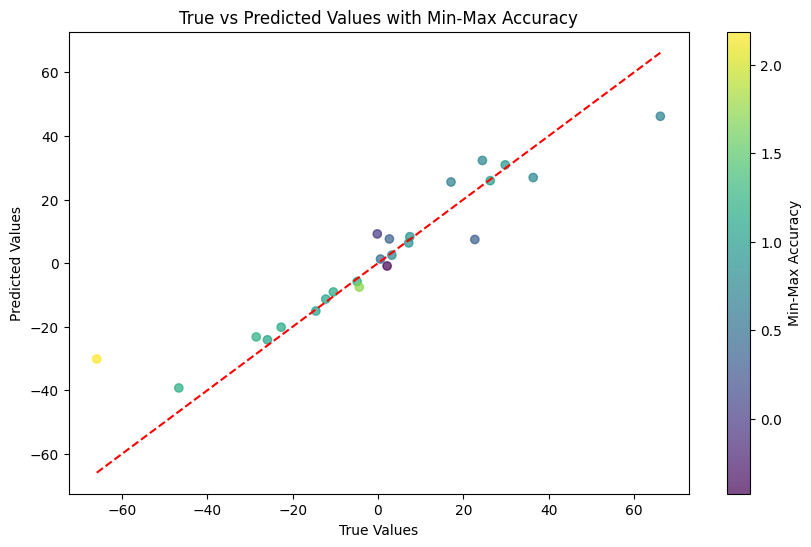

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate Min-Max Accuracy per prediction
min_max_accuracies = np.minimum(y_valid, y_pred) / np.maximum(y_valid, y_pred)

# Scatter plot of True vs Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_valid, y_pred, c=min_max_accuracies, cmap='viridis', alpha=0.7)
plt.colorbar(label='Min-Max Accuracy')
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'r--')  # Line for y = x
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values with Min-Max Accuracy')
plt.show()

In [ ]:
# Calculate the overall average Min-Max Accuracy
average_min_max_accuracy = np.mean(min_max_accuracies)
print(f"\nOverall Average Min-Max Accuracy: {average_min_max_accuracy:.2f}")



Overall Average Min-Max Accuracy: 0.88


In [ ]:
min_max_accuracies

,Overall Inflation Rate (%)
83,0.351951
4,0.985778
42,0.774885
40,0.670410
10,1.081459
47,1.126205
110,0.897347
36,-0.422159
70,-0.017736
11,1.182973


In [ ]:
import shap

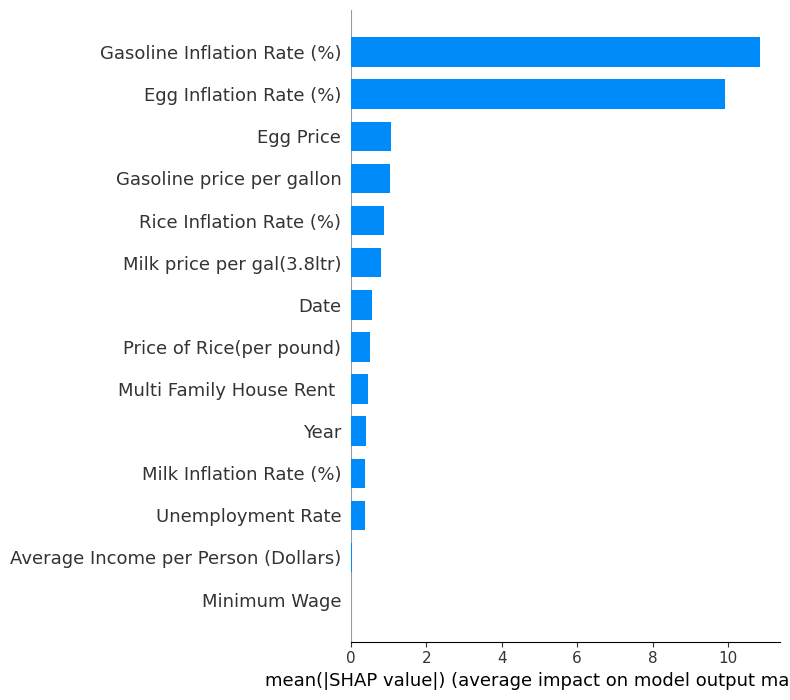

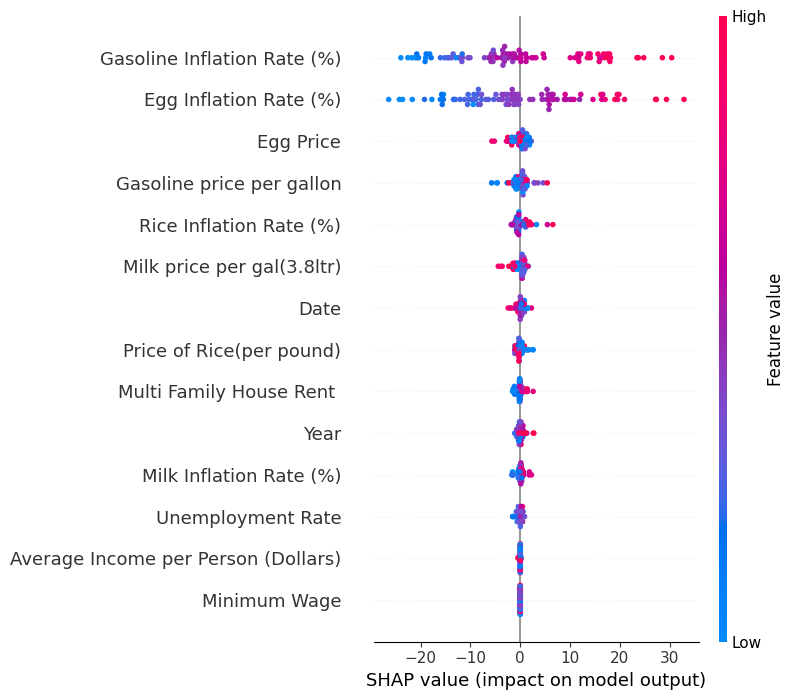

In [ ]:
# Initialize the SHAP explainer with the trained model and the training data
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# Summary plot for feature importance
shap.summary_plot(shap_values, X_train, plot_type="bar")

# Detailed summary plot showing the effect of each feature
shap.summary_plot(shap_values, X_train)

# Here, let's explain the first prediction in the test set
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_train.iloc[0])

In [ ]:
Data.columns

Index(['Year', 'Date', 'Price of Rice(per pound)', 'Gasoline price per gallon',
       'Milk price per gal(3.8ltr)', 'Egg Price', 'Rice Inflation Rate (%)',
       'Gasoline Inflation Rate (%)', 'Milk Inflation Rate (%)',
       'Egg Inflation Rate (%)', 'Minimum Wage',
       'Average Income per Person (Dollars)', 'Multi Family House Rent ',
       'Unemployment Rate', 'Overall Inflation Rate (%)'],
      dtype='object')

In [ ]:
from sklearn.metrics import mean_absolute_error

# List of random seeds to use
seeds = [58, 123, 456, 789, 1010]

# Store results from each run
shap_values_list = []
metric_results = []

for seed in seeds:
    # Set random seed
    np.random.seed(seed)

    # Split data
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=seed)

    # Convert 'Date' column to numerical representation before fitting
    X_train['Date'] = pd.to_numeric(X_train['Date'])
    X_valid['Date'] = pd.to_numeric(X_valid['Date'])

    # Initialize and train your model by XGBoost
    model = XGBRegressor(
        learning_rate=0.2806431064716795,
        max_depth=8,
        subsample=0.7595014469434788,
        colsample_bytree=0.9886160698958019,
        alpha=2.0088539941097943,
        reg_lambda=0.3584477313134125,
        n_estimators=272
    )

    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_valid)

    # Calculate MAE and store it
    mae = mean_absolute_error(y_valid, y_pred)
    metric_results.append(mae)

    # Calculate SHAP values
    explainer = shap.Explainer(model, X_train)
    shap_values = explainer(X_valid)
    shap_values_list.append(shap_values)

# Print MAE results for each seed
for seed, mae in zip(seeds, metric_results):
    print(f"Seed: {seed}, MAE: {mae}")

# Calculate the median MAE across all seeds
median_mae = np.median(metric_results)
print(f"Median MAE across all seeds: {median_mae}")


Seed: 58, MAE: 6.566624076353001
Seed: 123, MAE: 8.204578827733796
Seed: 456, MAE: 7.093534960263928
Seed: 789, MAE: 4.8762146121226175
Seed: 1010, MAE: 6.614012620597735
Median MAE across all seeds: 6.614012620597735


In [ ]:
import os

In [ ]:
# Creating a directory to save SHAP plots
os.makedirs("shap_plots", exist_ok=True)

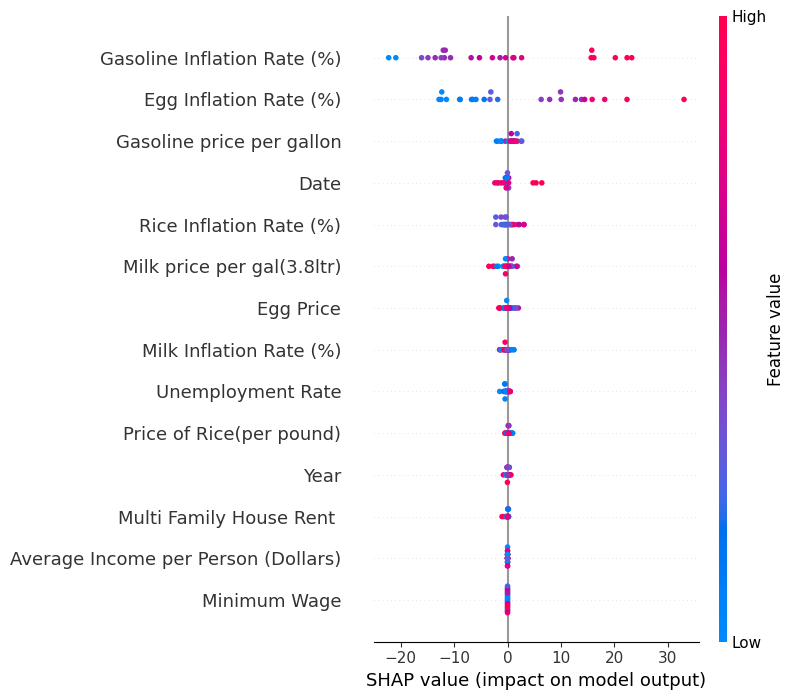

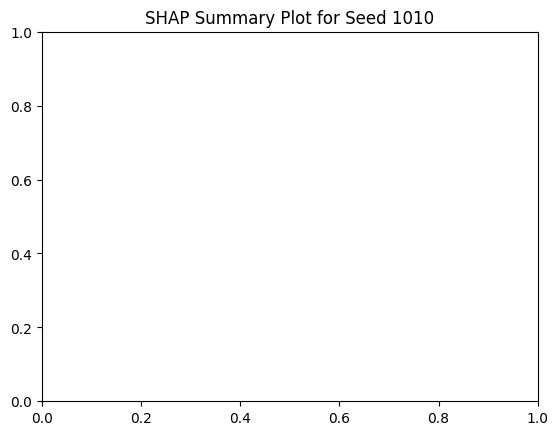

In [ ]:
# Plot SHAP summary for this seed
plt.figure()
shap.summary_plot(shap_values, X_valid, show=True)  # Show plot immediately for each seed
plt.title(f'SHAP Summary Plot for Seed {seed}')
plt.show()